(78585, 1047) (78585, 1)
241
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 1047, 32)          128       
                                                                 
 batch_normalization_24 (Bat  (None, 1047, 32)         128       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 1047, 32)          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 1047, 128)         12416     
                                                                 
 batch_normalization_25 (Bat  (None, 1047, 128)        512       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)    

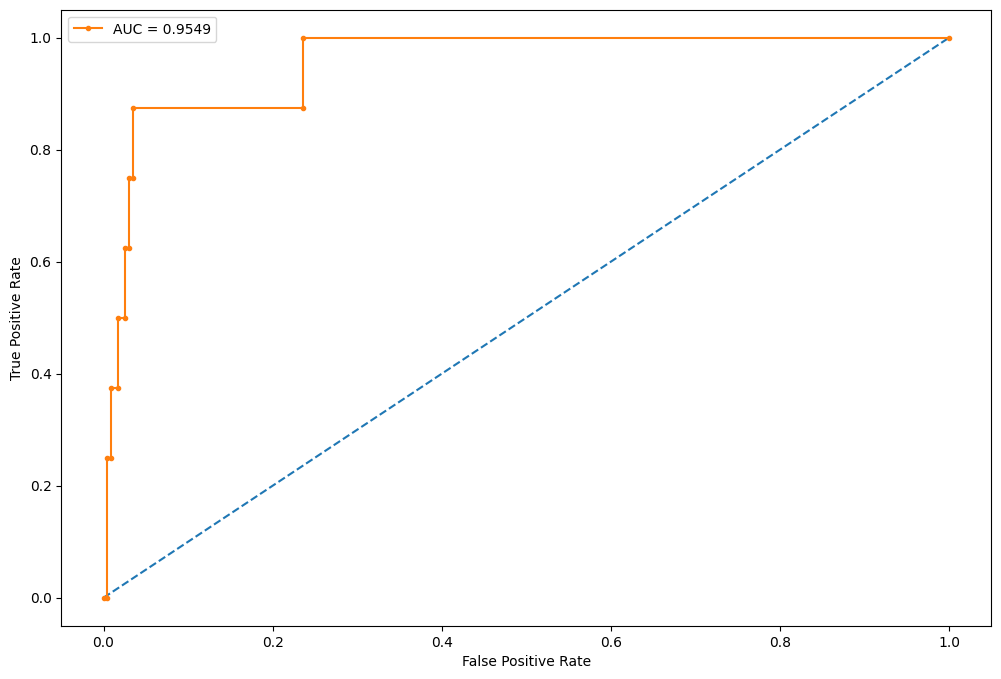

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score 
import warnings
import pickle 
import copy
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
import tensorflow as tf
import tensorflow.keras.layers as tfl

with open("features_data/diversity/train_dataset_1.pkl", 'rb') as file:
    positive_set = pickle.load(file)

with open("features_data/diversity/train_dataset_0.pkl", 'rb') as file:
    negative_set_entire = pickle.load(file)
column_names = ['pdb_name','residue','features','label']
# 确保 positive_set 和 negative_set_entire 是 DataFrame
if isinstance(positive_set, dict):
    positive_set = pd.DataFrame.from_dict(positive_set)
if isinstance(negative_set_entire, dict):
    negative_set_entire = pd.DataFrame.from_dict(negative_set_entire)

Negative_Samples = negative_set_entire.sample(n=round(len(positive_set)*14), random_state=42)

# combine positive and negative sets to make the final dataset
Train_set = pd.concat([positive_set, Negative_Samples], ignore_index=True, axis=0)

# collect the features and labels of train set
np.set_printoptions(suppress=True)
X_val = [0]*len(Train_set)
for i in range(len(Train_set)):
    feat = Train_set['features'][i]
    # feat = np.concatenate((feat[:1024],feat[1044:]))
    X_val[i] = feat
X_train_orig = np.asarray(X_val)
y_val = Train_set['label'].to_numpy(dtype=float)
Y_train_orig = y_val.reshape(y_val.size,1)

# Generate a random order of elements with np.random.permutation and simply index into the arrays Feature and label 
idx = np.random.permutation(len(X_train_orig))
X_train,Y_train = X_train_orig[idx], Y_train_orig[idx]
scaler = StandardScaler()
scaler.fit(X_train) # fit on training set only
X_train = scaler.transform(X_train) # apply transform to the training set
print(X_train.shape, Y_train.shape)




# load test data features_data/D157_dataset1.pkl
with open("allo_data/2V4Y_A_dataset.pkl", 'rb') as file:
    test_set_entire = pickle.load(file)
column_names = ['pdb_name','residue','features','label']
# 确保 positive_set 和 negative_set_entire 是 DataFrame
if isinstance(test_set_entire, dict):
    test_set = pd.DataFrame.from_dict(test_set_entire)
res_len=len(test_set['residue'])
print(res_len)
# collect the features and labels for independent set
X_independent = [0]*len(test_set)
for i in range(len(test_set)):
    feat1 = test_set['features'][i]
    X_independent[i] = feat1
X_test = np.asarray(X_independent)

y_independent = test_set['label'].to_numpy(dtype=float)
Y_test = y_independent.reshape(y_independent.size,1)

X_test = scaler.transform(X_test) # apply standardization (transform) to the test set

test_set
def CNN_Model():
    
    model = tf.keras.Sequential()
    model.add(tfl.Conv1D(32, 3, padding='same', activation='relu', input_shape=(feat_shape,1)))
    model.add(tfl.BatchNormalization())
    model.add(tfl.Dropout(0.2)) 

    model.add(tfl.Conv1D(128, 3, padding='same',activation='relu'))
    model.add(tfl.BatchNormalization())
    model.add(tfl.Dropout(0.3)) 

    model.add(tfl.Conv1D(32, 5, padding='same',activation='relu'))
    model.add(tfl.BatchNormalization()) 
    model.add(tfl.Dropout(0.2)) 

    model.add(tfl.Conv1D(32, 3, padding='same',activation='relu'))
    model.add(tfl.BatchNormalization()) 
    model.add(tfl.Dropout(0.3)) 

    model.add(tfl.Flatten())
    model.add(tfl.Dense(128, activation='relu'))


    model.add(tfl.Dense(32, activation='relu'))
    model.add(tfl.Dense(1, activation='sigmoid'))
    
    
    return model

feat_shape = X_test[0].size # number of features

cnn_model = CNN_Model()

learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
cnn_model.compile(optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=['AUC'])

cnn_model.summary()

# load the trained weights
# cnn_model.load_weights('model/embedding-pssm-bio/dataset_best_model_weights_rerun_8.h5')
cnn_model.load_weights('myModel/all.h5')
eval_result = cnn_model.evaluate(X_test, Y_test)

print(f"test loss: {round(eval_result[0],4)}, test auc: {round(eval_result[1],4)}")
Inde_test_prob = cnn_model.predict(X_test)


for i, prob in enumerate(Inde_test_prob):
    # print(f"Sample {i}: Probability of being positive class = {prob[0]}")
    if(prob[0]>0.5):
        # print(X_test[i])
        print(f"Sample {i}: Probability of being positive class = {prob[0]}")
        # 输出别构残基的resid
        print(f"african_sites:{test_set['residue'][i]}")

def round_based_on_thres(probs_to_round, set_thres):
    for i in range(len(probs_to_round)):
        if probs_to_round[i] <= set_thres:
            probs_to_round[i] = 0
        else:
            probs_to_round[i] = 1
    return probs_to_round

# calculate the metrics #0.877
set_thres = 0.5
copy_Probs_inde = copy.copy(Inde_test_prob)
round_based_on_thres(copy_Probs_inde, set_thres)
fpr, tpr, thresholds = roc_curve(Y_test, Inde_test_prob)

inde_auc = round(roc_auc_score(Y_test, Inde_test_prob),4)
inde_pre = round(precision_score(Y_test, copy_Probs_inde),4)
cm = confusion_matrix(Y_test, copy_Probs_inde) # for acc, sen, and spe calculation
total_preds=sum(sum(cm))
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]
inde_sen = round(TP/(TP+FN),4)
inde_spe = round(TN/(TN+FP),4)
mcc = round((cm[0,0]*cm[1,1]-cm[0,1]*cm[1,0])/np.sqrt((cm[0,0]+cm[0,1])*(cm[0,0]+cm[1,0])*(cm[1,1]+cm[1,0])*(cm[1,1]+cm[0,1])),4)
acc = round((TP+TN)/total_preds,4)
F1 = 2*(inde_pre*inde_sen)/(inde_pre+inde_sen)
# display the metrics
print(f'Independent Sen: {inde_sen}')
print(f'Independent Spe: {inde_spe}')
print(f'Independent Pre: {inde_pre}')
print(f'Independent AUC: {inde_auc}')
print(f'Independent MCC: {mcc}')
print(f'ACC: {acc}')
print(f'F1: {F1}')
# plot ROC curve
legend = 'AUC = ' + str(inde_auc)
pyplot.figure(figsize=(12,8))
pyplot.plot([0,1], [0,1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.', label=legend)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()